<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# autoreload updated and newly installed packages
# without having to restart Jupyter kernel
%load_ext autoreload
%autoreload 2
# Some little interaction with matplotlib
%matplotlib inline
# Avoid using Jedi for faster autocomplete (tab)
%config Completer.use_jedi = False

# Significance of fatigue cycles depending on their frequency

In [2]:
# Backwards compatibility of the cluster_df function with python 3.8.X
from __future__ import annotations

# Standard imports
import ast
import copy
import datetime
import platform
import os
import sys
import time
from typing import List, Any
from collections import ChainMap, defaultdict

# Non-standard imports
from pandas.tseries.frequencies import to_offset
from pathlib import Path
try:
    from tqdm import tqdm
except ImportError:
    print("Install the 'tqdm' module within your environment using pip")
import matplotlib
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import pandas as pd
import plotly.graph_objs as go

# py-fatigue import
import py_fatigue as pf
import py_fatigue.testing as test
# Paths of this tutorial and of the data
TUTORIAL_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(Path.home(), "Documents", "Work", "data")
if not TUTORIAL_PATH in sys.path:
    sys.path.append(TUTORIAL_PATH)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
print(f"Platform: {platform.platform()}")
print(f"Python version: {sys.version}")
print(f"py-fatigue version: {pf.styling.TermColors.CBOLD}{pf.__version__}")

print(f"{pf.styling.TermColors.CWHITEBG}\
{pf.styling.TermColors.CBOLD}\
{pf.styling.TermColors.CBLUE}")
      
print(f"DATA_PATH = {DATA_PATH}")
print(f"TUTORIAL_PATH = {TUTORIAL_PATH}")

print(f"{pf.styling.TermColors.CEND}")

Platform: Linux-5.19.0-26-generic-x86_64-with-glibc2.35
Python version: 3.8.15 (default, Dec 14 2022, 14:18:12) 
[GCC 12.2.0]
py-fatigue version: 1.0.9

DATA_PATH = /home/pd/Documents/Work/data
TUTORIAL_PATH = /home/pd/Python/Packages/Github/py-fatigue



In [4]:
plt.rcParams["figure.figsize"] = (7, 3.5)
plt.rcParams["font.family"] = ["Sans-Serif"]
plt.rcParams["font.size"] = 10
plt.rcParams["lines.markersize"] = 3
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.color"] = "#DDDDDD"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.minor.bottom"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.labelbottom"] = True
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.minor.left"] = True
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.labelleft"] = True
plt.rcParams["image.cmap"] = "Paired"
plt.rcParams['axes.prop_cycle'] = matplotlib.rcsetup.cycler(
    'color',
    ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e']
)

## 1. Data handling

### Import the data from csv file

The following operations are run:

1. Read .csv file containing cyce-counts in the form of py-fatigue sparse json
2. Set 'timestamp' as index
3. Convert literal columns containing the json cycle-counts to python dictionaries

In [5]:
start = time.time()
# 1
print(f"\33[36m1. Read \33[1m.csv\33[22m file\33[0m")
df_ = pd.read_csv(os.path.join(DATA_PATH, "CC_BB_C01_SS_2018_TO_2021.csv"))
# 2
print(f"\33[36m2. Set \33[1m'timestamp'\33[22m as index\33[0m")
df_ = df_.set_index("timestamp")
df_.index = pd.to_datetime(df_.index)
# 3
for col in df_.columns:
    if col.startswith("CC_"):
        tqdm.pandas(desc=f"\33[36m3. Converting \33[1m{col[:3]}{col[13:]}\33[0m") 
        df_[col] = df_[col].progress_apply(
            lambda x: ast.literal_eval(x) if not x!=x else x
        )
end = time.time()
print(f"\nElapsed time is {np.round(end-start, 0)}, s.")

1. Read .csv file
2. Set 'timestamp' as index


3. Converting CC_SG_LAT019_DEG025_0_nr1: 100%|█| 157861/157861 [00:22<00:00, 697
3. Converting CC_SG_LAT019_DEG085_0_nr1: 100%|█| 157861/157861 [00:27<00:00, 577
3. Converting CC_SG_LAT019_DEG145_0_nr1: 100%|█| 157861/157861 [00:26<00:00, 592
3. Converting CC_SG_LAT019_DEG205_0_nr1: 100%|█| 157861/157861 [00:22<00:00, 701
3. Converting CC_SG_LAT019_DEG265_0_nr1: 100%|█| 157861/157861 [00:28<00:00, 549
3. Converting CC_SG_LAT019_DEG325_0_nr1: 100%|█| 157861/157861 [00:44<00:00, 352


Elapsed time is 178.0, s.


<div class="alert alert-block alert-warning">
<b> ⚠️ Fallback:</b> In case we mess up with the main dataframe (<tt>df</tt>) used for the subsequent analyses, we keep <tt>df_</tt> intact as a fallback.
</div>


In [6]:
df = copy.deepcopy(df_)

### From `dict` to `CycleCount`

The following part is still in the "managing the input data" workflow, as it converts the rainflow dictionaries to `pf.CycleCount` instances.

In [7]:
# 4
start = time.time()
tqdm.pandas(desc=f"\33[36m4. From \33[1mdict \33[22mto \33[1mpf.CycleCount\33[0m")
for col in df.columns:
    if col.startswith("CC_"):
        df[col] = df.progress_apply(
            lambda x: pf.CycleCount.from_rainflow(
                x[col], name=col[13:], timestamp=x.name
            ) if not x[col]!=x[col] else x[col], axis=1
        )
end = time.time()
print(f"\nElapsed time is {np.round(end-start, 0)}, s.")

4. From dict to pf.CycleCount: 100%|██| 157861/157861 [00:33<00:00, 4770.61it/s]


Elapsed time is 512.0, s.


### Aggregate the `CycleCounts` in `df` by a time window

The following part of the notebook makes extensive usage of the aggregation functionalities provided by [pandas.Dataframe.agg()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html). In order, the following operations are performed:

- Optionally, a subset of the dataframe can be taken for the analysis.
- A set of aggregations in the form of [pandas date offset frequency strings](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) has to be assigned. In this example we use: `'T'` (aggregate timestamps within every minute), `'D'` (day), `'W'` (week), `'M'` (month), `'Q'` (quarter), `'Y'` (year). In addition, we use also the `'all'` aggregation which simply aggregates the entire time window.
- Checks are run in order to verify that the aggregations have been assigned in increasing time-range order. This requirement is important in the final part (bar plot).
- The `pf.cycle_count.utils.aggregate_cc()` is run. The function returns:
    - The dataframe aggregated by the key assigned (e.g. `'W'`)
    - The sequence of residuals and their order of appearence. This datum is interesting to compare with the results of the bar plot.


In [8]:
n_days = 60
wf = copy.deepcopy(df).head(144 * n_days)  # Select the needed days (144 × n_days)

In [9]:
aggregations = ["T", "D", "W", "M", "Q", "Y"]

In [10]:
df_agg = dict()
hc = dict()
common_dt = pd.to_datetime("2000-01-01")
if "all" in aggregations:
    aggregations.pop("all")
time_ = [common_dt + to_offset(to) for to in aggregations]
sorted_aggregations = [x for _, x in sorted(zip(np.argsort(time_), aggregations))]
sorted_aggregations.append("all")
for aggr in sorted_aggregations:
    df_agg[aggr], hc[aggr] = pf.cycle_count.utils.aggregate_cc(wf, aggr)

1. Running checks on df.
2. Building the aggregation dict.
3. Aggregate df by 'T'.
4. Retrieving LFFD on aggregated df.
5. Saving the residuals sequences.
Elapsed time for 'T' aggregation is 13.0, s.

1. Running checks on df.
2. Building the aggregation dict.
3. Aggregate df by 'D'.
4. Retrieving LFFD on aggregated df. -> 100% completed... 
5. Saving the residuals sequences.
Elapsed time for 'D' aggregation is 77.0, s.

1. Running checks on df.
2. Building the aggregation dict.
3. Aggregate df by 'W'.
4. Retrieving LFFD on aggregated df. -> 100% completed...  
5. Saving the residuals sequences.
Elapsed time for 'W' aggregation is 23.0, s.

1. Running checks on df.
2. Building the aggregation dict.
3. Aggregate df by 'M'.
4. Retrieving LFFD on aggregated df. -> 100% completed... . 
5. Saving the residuals sequences.
Elapsed time for 'M' aggregation is 16.0, s.

1. Running checks on df.
2. Building the aggregation dict.
3. Aggregate df by 'Q'.
4. Retrieving LFFD on aggregated df.0m -> 10

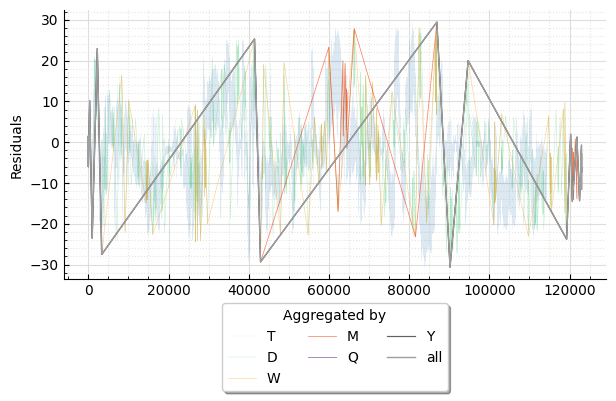

(<Figure size 700x350 with 1 Axes>,
 <AxesSubplot: xlabel='Residuals sequence', ylabel='Residuals'>)

In [11]:
plt_prmtr = "CC_BB_C01_TP_SG_LAT019_DEG325_0_nr1"
pf.cycle_count.utils.plot_aggregated_residuals(
    hc,
    plt_prmtr,
)

## Fatigue calculation

### SN curves

We want to define a set of SN curves that produce some realistic damage figures. To this aim, we take one of the sn curves from DNV-RP-C203 (specifically the D curve with free corrosion), and use that as baseline.

Given $\bar{m}$, $\ln\bar{a}$, and a number of cycles $\bar{N}$ where we want the SN curves to intersect (e.g. $1E7$), the intersection stress range is given by:

$$
    \ln{\bar{\sigma}} = \dfrac{\ln{\bar{a}} - \ln{\bar{N}}}{\bar{m}}\\
$$

From the point $\left(\ln{\bar{N}}, \ln{\bar{\sigma}} \right)$, it is possible to calculate the intersect $\ln{a}$ for each slope $m$ as:

$$
    \ln{a} = m \ln{\bar{\sigma}} + \ln{\bar{N}}
$$

In [12]:
m_hat = 3
log_a_hat = 11.687
log_N_hat = 7
log_sigma_hat = (log_a_hat - log_N_hat) / m_hat

if log_sigma_hat <= 0:
    raise ValueError("log(a) <= log(N).\n\nThat is not possible.")

log_a_hat_m4 = 4 * log_sigma_hat + log_N_hat
log_a_hat_m5 = 5 * log_sigma_hat + log_N_hat

sn = defaultdict()
sn['DNV-D-C (m=3)'] = pf.SNCurve(
    slope=m_hat,
    intercept=log_a_hat,
    curve="D, m=3",
    environment="Free corrosion",
    norm="DNVGL-RP-C203",
    unit_string="MPa"
)

sn['DNV-D-C (m=4)'] = pf.SNCurve(
    slope=4,
    intercept=log_a_hat_m4,
    curve="D, m=4",
    environment="Free corrosion",
    norm="DNVGL-RP-C203",
    unit_string="MPa"
)

sn['DNV-D-C (m=5)'] = pf.SNCurve(
    slope=5,
    intercept=log_a_hat_m5,
    curve="D, m=5",
    environment="Free corrosion",
    norm="DNVGL-RP-C203",
    unit_string="MPa"
)


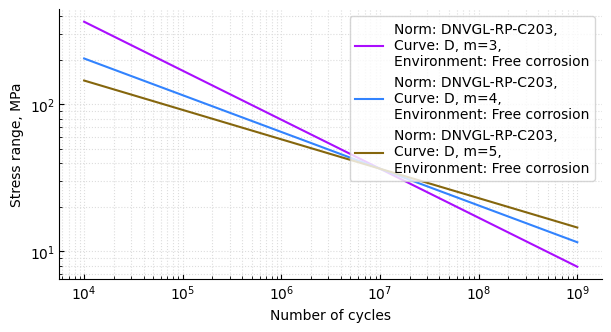

In [13]:
fig, ax = plt.subplots()
for k, s in sn.items():
    s.plot(fig=fig, ax=ax)
plt.legend()
plt.show()

### Apply Palmgren-Miner rule

The Palmgren-Miner rule is applied to the aggregated damages using the `py_fatigue.cycle_count.utils.calc_aggregated_damage()` function which takes as input the aggregated dataframe and a dict or sequence of SN curves.

In [130]:
dict_df_dmg = dict()
for aggr, df_d in df_agg.items():
    dict_df_dmg[aggr] = pf.cycle_count.utils.calc_aggregated_damage(df_d, sn)

The variable `dict_df_dmg` is a dictionary that contains the date offset frequency strings as keys and the corresponding multi-indexed dataframes as values.

The multi-index dataframe contains the `'timestamp'` and `'sn_curve'` columns as indices, and the cycle-counted parameters names as column names.

To access a multi-index dataframe from within the `dict_df_dmg` dictionary, you can follow this logic:

```python
aggr_key = "W"
sn_curve_lookup = "m=[4.]"
dict_df_dmg[aggr_key].loc[sn_curve_lookup]
```

In [129]:
dict_df_dmg["T"].loc["m=[3.]"]

,CC_BB_C01_TP_SG_LAT019_DEG325_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG265_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG205_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG145_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG085_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG025_0_nr1
timestamp,,,,,,
2018-01-01 00:00,2.212203e-08,5.086823e-08,5.559453e-08,2.524927e-08,5.263227e-08,4.580187e-08
2018-01-01 00:10,1.487716e-08,2.402940e-08,2.752225e-08,1.713357e-08,2.510921e-08,2.300675e-08
2018-01-01 00:20,1.572248e-08,3.681439e-08,2.244739e-08,1.896345e-08,3.774846e-08,1.862050e-08
2018-01-01 00:30,2.164710e-08,4.683531e-08,3.471193e-08,2.548651e-08,4.841821e-08,2.861488e-08
2018-01-01 00:40,2.915069e-08,5.284708e-08,2.979496e-08,3.545777e-08,5.346285e-08,2.487801e-08
...,...,...,...,...,...,...
2018-03-01 23:10,1.765433e-08,3.216767e-08,1.378914e-08,1.919010e-08,3.274083e-08,1.137839e-08
2018-03-01 23:20,1.255602e-08,2.603482e-08,1.011545e-08,1.409651e-08,2.636136e-08,8.393330e-09
2018-03-01 23:30,1.463705e-08,3.524608e-08,1.323564e-08,1.652497e-08,3.562936e-08,1.092376e-08


### Aggregation of damages into total damage

Damages now are summed up in the entire time-window for each date offset aggregation type to obtain the final damages.

In [134]:
df_dmg_agg = pd.DataFrame()
for aggr, df_d in dict_df_dmg.items():
    
    df_1 = df_d.groupby(["sn_curve"]).agg("sum")
    df_1["aggregate_by"] = aggr
    df_dmg_agg = pd.concat([df_dmg_agg, df_1])
# df_dmg_agg = df_dmg_agg.transpose()
df_dmg_agg = df_dmg_agg.set_index([df_dmg_agg.index, "aggregate_by"])

In [135]:
df_dmg_end = df_dmg_agg.loc["m=[4.]"]

In [136]:
df_dmg_end

,CC_BB_C01_TP_SG_LAT019_DEG325_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG265_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG205_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG145_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG085_0_nr1,CC_BB_C01_TP_SG_LAT019_DEG025_0_nr1
aggregate_by,,,,,,
T,0.000013,0.000019,0.000020,0.000014,0.000020,0.000015
D,0.000017,0.000023,0.000024,0.000018,0.000024,0.000018
W,0.000018,0.000024,0.000025,0.000018,0.000026,0.000019
M,0.000018,0.000025,0.000026,0.000019,0.000027,0.000020
Q,0.000018,0.000025,0.000026,0.000019,0.000027,0.000020
Y,0.000018,0.000025,0.000026,0.000019,0.000027,0.000020
all,0.000018,0.000025,0.000026,0.000019,0.000027,0.000020


In [137]:
df_norm = df_dmg_end.div(df_dmg_end.max())
df_norm = pd.concat([df_norm.loc["T"].to_frame().T, df_norm.diff()[1:]],
                     ignore_index=True)
df_norm.index = df_dmg_end.index

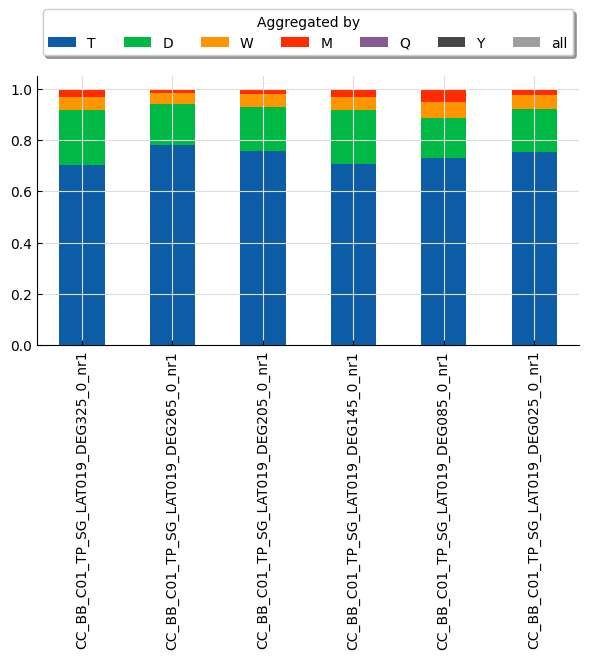

In [140]:
df_norm.transpose().plot.bar(stacked=True)
plt.legend(
    title="Aggregated by",
    loc="lower center",
    fancybox=True,
    bbox_to_anchor=(0.5, 1.05),
    ncol=7,
    shadow=True,
)

In [126]:
sn_list = list(sn.values())

In [127]:
{sk.name: sk for sk in sn_list}

{'Norm: DNVGL-RP-C203,\nCurve: D, m=3,\nEnvironment: Free corrosion': <py_fatigue.material.sn_curve.SNCurve at 0x7f5ed58542e0>,
 'Norm: DNVGL-RP-C203,\nCurve: D, m=4,\nEnvironment: Free corrosion': <py_fatigue.material.sn_curve.SNCurve at 0x7f5ed5854280>,
 'Norm: DNVGL-RP-C203,\nCurve: D, m=5,\nEnvironment: Free corrosion': <py_fatigue.material.sn_curve.SNCurve at 0x7f5ed5854310>}